In [1]:
!rm -rf data*
!rm -rf train
!rm -rf test

!wget https://www.dropbox.com/s/0ltu370va0p4vct/data.tgz
!tar xzf data.tgz

--2018-05-17 19:12:11--  https://www.dropbox.com/s/0ltu370va0p4vct/data.tgz
S'està resolent www.dropbox.com (www.dropbox.com)... 162.125.68.1, 2620:100:6024:1::a27d:4401
S'està connectant a www.dropbox.com (www.dropbox.com)|162.125.68.1|:443... conectat.
HTTP: s'ha enviat la petició, s'està esperant una resposta... 302 Found
Ubicació: https://dl.dropboxusercontent.com/content_link/4zhsl3jlFOaRikqeJ2GiX5bKXFKwwOmqe7EuXmOAcWwHZfYnyjbMzcopmRWEyl6r/file [es segueix]
--2018-05-17 19:12:11--  https://dl.dropboxusercontent.com/content_link/4zhsl3jlFOaRikqeJ2GiX5bKXFKwwOmqe7EuXmOAcWwHZfYnyjbMzcopmRWEyl6r/file
S'està resolent dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.68.6, 2620:100:6024:6::a27d:4406
S'està connectant a dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.68.6|:443... conectat.
HTTP: s'ha enviat la petició, s'està esperant una resposta... 200 OK
Mida: 223429043 (213M) [application/x-gtar]
S'està desant a: «data.tgz»

data.tgz            100%[=====

In [1]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/home/secorec/anaconda3/envs/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X = []
for filename in os.listdir('train/'):
    X.append(img_to_array(load_img('train/'+filename)))
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X
print(Xtrain.shape)

(516, 256, 256, 3)


In [3]:
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('data/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()
print("Cargar modelo inception (instalar si hace falta h5py, pip3 install h5py)")

Cargar modelo inception (instalar si hace falta h5py, pip3 install h5py)


In [4]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
print("Crear modelo con doble entrada, una imagen de 256x256 para el encoder-decoder y un vector de 1000 del Inception")

Crear modelo con doble entrada, una imagen de 256x256 para el encoder-decoder y un vector de 1000 del Inception


In [6]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 100

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)

print("Crear embeding y data generator")

Crear embeding y data generator


In [7]:
model.compile(optimizer='adam', loss='mse')
model.fit_generator(image_a_b_gen(batch_size),
                    epochs=200,
                    steps_per_epoch=5,
                    verbose=1)
print("Compilar y entrenar")

Epoch 1/200
5/5 [==============================] - 56s 11s/step - loss: 0.0960
Epoch 2/200
5/5 [==============================] - 39s 8s/step - loss: 0.0049
Epoch 3/200
5/5 [==============================] - 39s 8s/step - loss: 0.0049
Epoch 4/200
5/5 [==============================] - 39s 8s/step - loss: 0.0048
Epoch 5/200
5/5 [==============================] - 39s 8s/step - loss: 0.0049
Epoch 6/200
5/5 [==============================] - 38s 8s/step - loss: 0.0048
Epoch 7/200
5/5 [==============================] - 47s 9s/step - loss: 0.0048
Epoch 8/200
5/5 [==============================] - 39s 8s/step - loss: 0.0047
Epoch 9/200
5/5 [==============================] - 39s 8s/step - loss: 0.0047
Epoch 10/200
5/5 [==============================] - 39s 8s/step - loss: 0.0048
Epoch 11/200
5/5 [==============================] - 39s 8s/step - loss: 0.0048
Epoch 12/200
5/5 [==============================] - 38s 8s/step - loss: 0.0049
Epoch 13/200
5/5 [==============================] - 47s 9s/s

KeyboardInterrupt: 

In [7]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("color_tensorflow_real_mode.h5")
print("Salvar el modelo")

Salvar el modelo


In [8]:
color_me = []
for filename in os.listdir('test/'):
    color_me.append(img_to_array(load_img('test/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me
color_me = gray2rgb(rgb2gray(color_me))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))


# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("result/img_"+str(i)+".png", lab2rgb(cur))
print("Probar el modelo con imagenes de test")

/home/secorec/anaconda3/envs/env/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Probar el modelo con imagenes de test


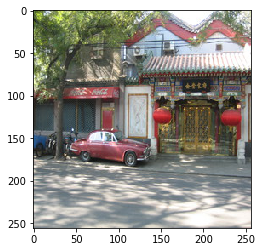

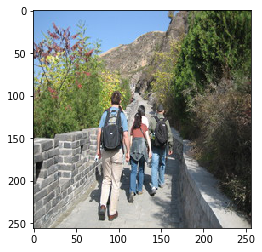

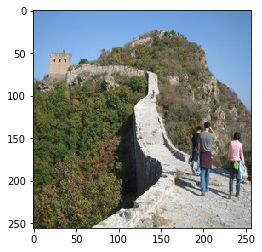

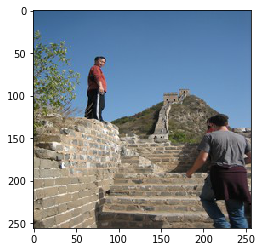

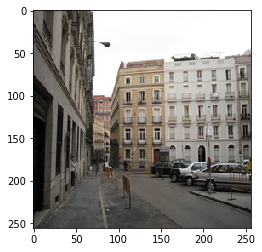

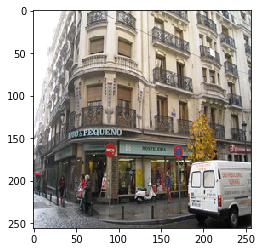

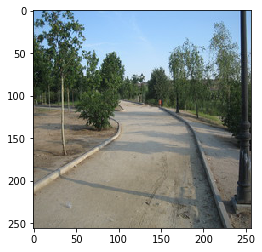

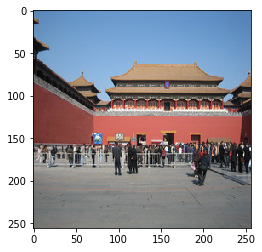

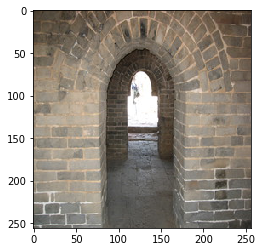

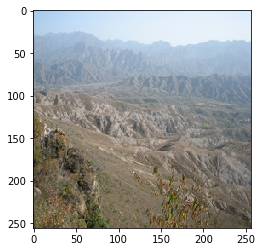

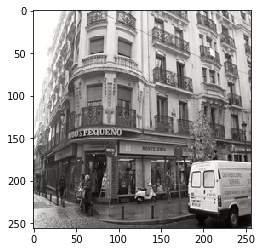

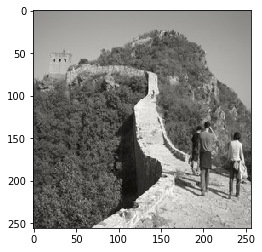

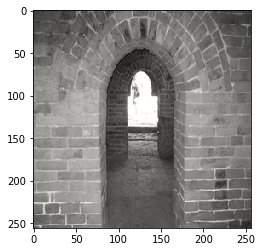

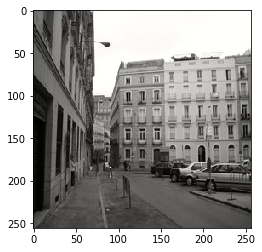

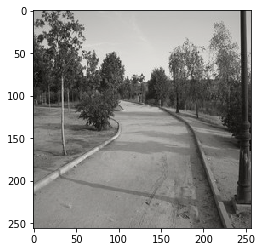

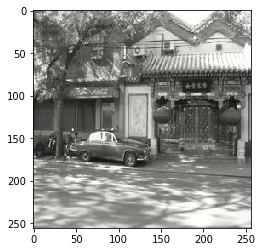

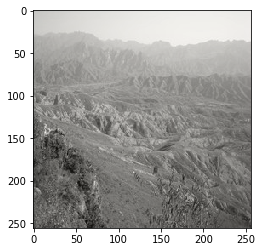

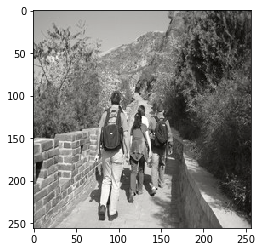

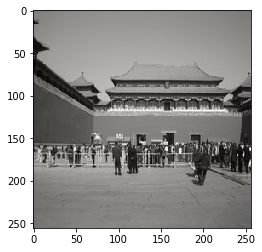

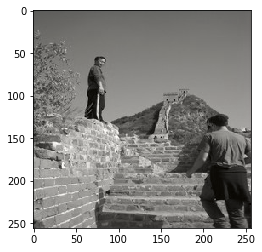

In [9]:
for filename in os.listdir('test/'):
  img=mpimg.imread('test/'+filename)
  imgplot = plt.imshow(img)
  plt.show()

for filename in os.listdir('result/'):
  img=mpimg.imread('result/'+filename)
  imgplot = plt.imshow(img)
  plt.show()